# *News Title Classification Report - Decision Tree +  Multinomial Naive Bayes + Artificial Neural Network*


# Group 6, Team Members:
* Moeung Chantpanha
* Mornsambath Thornin
* Mom Sombrathna
* Yon Chhailong
* Pho Sophors

# Introduction
This report presents the application of three different machine learning classifiers for news classification based on a dataset obtained from four News websites under four categories. The classifiers used are Decision Tree, Multinomial Naive Bayes, and Artificial Neural Network. The primary goal is to evaluate the performance of these models in classifying news articles into different categories.

## Running on JupyterNotebook
Activate env with installed libraries
* *conda activate Assignment*


# Know About data
For this assignment we scrape data from four news websites, which contain news articles including their Titles and Categories.

## Import Libraries
Import all necessary python libraries.


In [1]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import re
import nltk
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

import warnings

warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/macbookpro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


 # Data preparation
   ## Load data
 Load the data from news_head.csv file. We will clean the dataset preparing for training the dataset.

There are four categories in this dataset i.e. Business, Technology, Entertainment and Health.

In [2]:
src_filepath = "test_dataset.csv"
# Read the CSV file into a pandas DataFrame
df = pd.read_csv(src_filepath, encoding='utf-8', engine='python')

# Filter rows based on selected categories
selected_categories = ['b', 't', 'e', 'm']
df_filtered = df[df['CATEGORY'].isin(selected_categories)]

# Extract titles and categories from the DataFrame
titles = df_filtered['TITLE'].tolist()
categories = df_filtered['CATEGORY'].tolist()
df.columns

Index(['TITLE', 'CATEGORY'], dtype='object')

## Clean Data:

We clean the dataset by converting all titles into lowercase,  remove all characters that are not letters, numbers, or spaces.

In [3]:
# Clean the titles
cleaned_titles = []
for title in titles:
    if isinstance(title, str):
        cleaned_title = re.sub(r'[^a-zA-Z0-9\s]', '', title)
        cleaned_title = cleaned_title.lower()
        cleaned_titles.append(cleaned_title)
    else:
        # Handle non-string (float) values
        cleaned_titles.append(str(title))

# Create a DataFrame with cleaned titles and categories
data = {'Cleaned Titles': cleaned_titles, 'Categories': categories}
df_cleaned = pd.DataFrame(data)

# Print the DataFrame
df_cleaned.head(10)

,Cleaned Titles,Categories
0,latest on the campaign trail with just 2 days ...,b
1,snowy weather cancels iowa caucus events,b
2,iowa caucus preview,b
3,gma life sat jan 13 2024,b
4,former president trump back in court for closi...,b
5,new report shows wholesale prices dropped,b
6,ny ag trump defense team deliver closing argum...,b
7,iowa caucuses 3 days away,b
8,trump speaks after defenses closing arguments ...,b
9,closing arguments set for trump civil case,b


In [4]:
# Check for missing data
if(any(df_cleaned.isnull().any())):
    print('Missing Data\n')
    print(df_cleaned.isnull().sum())
else:
    print('NO missing data')

NO missing data


In [7]:
# check for duplicate
if(any(df_cleaned.duplicated())==True):
    print('Duplicate rows found')
    print('Number of duplicate rows= ', df_cleaned[df_cleaned.duplicated()].shape[0])
    df_cleaned.drop_duplicates(inplace=True,keep='first')
    df_cleaned.reset_index(inplace=True,drop=True)
    print('Dropping duplicates\n')
    print(df_cleaned.shape)
else:
    print('NO duplicate data')

NO duplicate data


## Split data

Split data into 2 parts - training and test. We will use training data to train out model and use test data to see how our model performs.


In [6]:
# Split the dataset into training and testing sets for titles and categories
X_train, X_test, Y_train, Y_test = train_test_split(titles, categories)
# 80:20 Split, X=Title, Y=Category

# Print the lengths of the resulting sets for overview
print("Training:", len(X_train))
print("Testing:", len(X_test))

Training: 14928
Testing: 4977


## Data Preprocessing

### Vectorization of data

Vectorize the data using Bag of words (BOW)

It prepares text data for machine learning by turning it into numerical features and encoding target labels, with an example of how to apply the model to new text.


In [8]:
# Check for NaN values in 'text' column
nan_indices = df['TITLE'].index[df['TITLE'].isnull()]

# Handle NaN values (replace NaN with an empty string)
df['TITLE'] = df['TITLE'].fillna('')

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(df['TITLE'], df['CATEGORY'], test_size=0.2, random_state=42)

# Tokenization: Use a regular expression tokenizer to extract words.
tokenizer = nltk.tokenize.RegexpTokenizer(r"\w+")

# Stopword Removal: Load English stopwords from NLTK.
stop_words = nltk.corpus.stopwords.words("english")

# Count Vectorization: Create a CountVectorizer with custom tokenizer and stop words.
vectorizer = CountVectorizer(tokenizer=tokenizer.tokenize, stop_words=stop_words)

# Fit and Transform Training Data:
vectorizer.fit(iter(X_train))  # Learn the vocabulary from training titles.
Xtr = vectorizer.transform(iter(X_train))  # Transform training titles to feature vectors.
Xte = vectorizer.transform(iter(X_test))  # Transform test titles.

# Label Encoding: Encode category labels into numerical values.
encoder = LabelEncoder()
encoder.fit(Y_train)
Ytr = encoder.transform(Y_train)
Yte = encoder.transform(Y_test)

# Reverse Vocabulary: Create a reverse mapping from indices to words.
reverse_vocabulary = {}
vocabulary = vectorizer.vocabulary_
for word in vocabulary:
    index = vocabulary[word]
    reverse_vocabulary[index] = word


## Feature Reduction

We can check the variance of the feature and drop them based on a threshold to gain efficiency ot the model.


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorization: Convert text data to TF-IDF matrix.
tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenizer.tokenize, stop_words=stop_words)
Xtr_tfidf = tfidf_vectorizer.fit_transform(iter(X_train))
Xte_tfidf = tfidf_vectorizer.transform(iter(X_test))

# Print the number of features before feature reduction.
print("Number of features before reduction : ", Xtr_tfidf.shape[1])

# Create a VarianceThreshold object with a threshold of 0.001
selection = VarianceThreshold(threshold=0.001)

# Fit the VarianceThreshold on the training data and transform all datasets
selection.fit(Xtr_tfidf)
Xtr_tfidf_reduced = selection.transform(Xtr_tfidf)
Xte_tfidf_reduced = selection.transform(Xte_tfidf)

# Print the number of features after feature reduction.
print("Number of features after TF-IDF feature extraction and reduction : ", Xtr_tfidf_reduced.shape[1])

Number of features before reduction :  15019
Number of features after TF-IDF feature extraction and reduction :  51


## Train Models

### Decision Tree



In [10]:
# Create a Decision Tree classifier
dt = DecisionTreeClassifier()

# Train the Decision Tree on the training data
dt.fit(Xtr, Ytr)

# Make predictions on the test set
pred = dt.predict(Xte)

# Print the classification report, including precision, recall, and F1-score
print("Decision Tree Classifier:")
print(classification_report(Yte, pred, target_names=encoder.classes_))

Decision Tree Classifier:
              precision    recall  f1-score   support

           b       0.90      0.86      0.88       824
           e       0.88      0.86      0.87       847
           t       0.92      0.94      0.93      2310

    accuracy                           0.91      3981
   macro avg       0.90      0.89      0.89      3981
weighted avg       0.91      0.91      0.91      3981



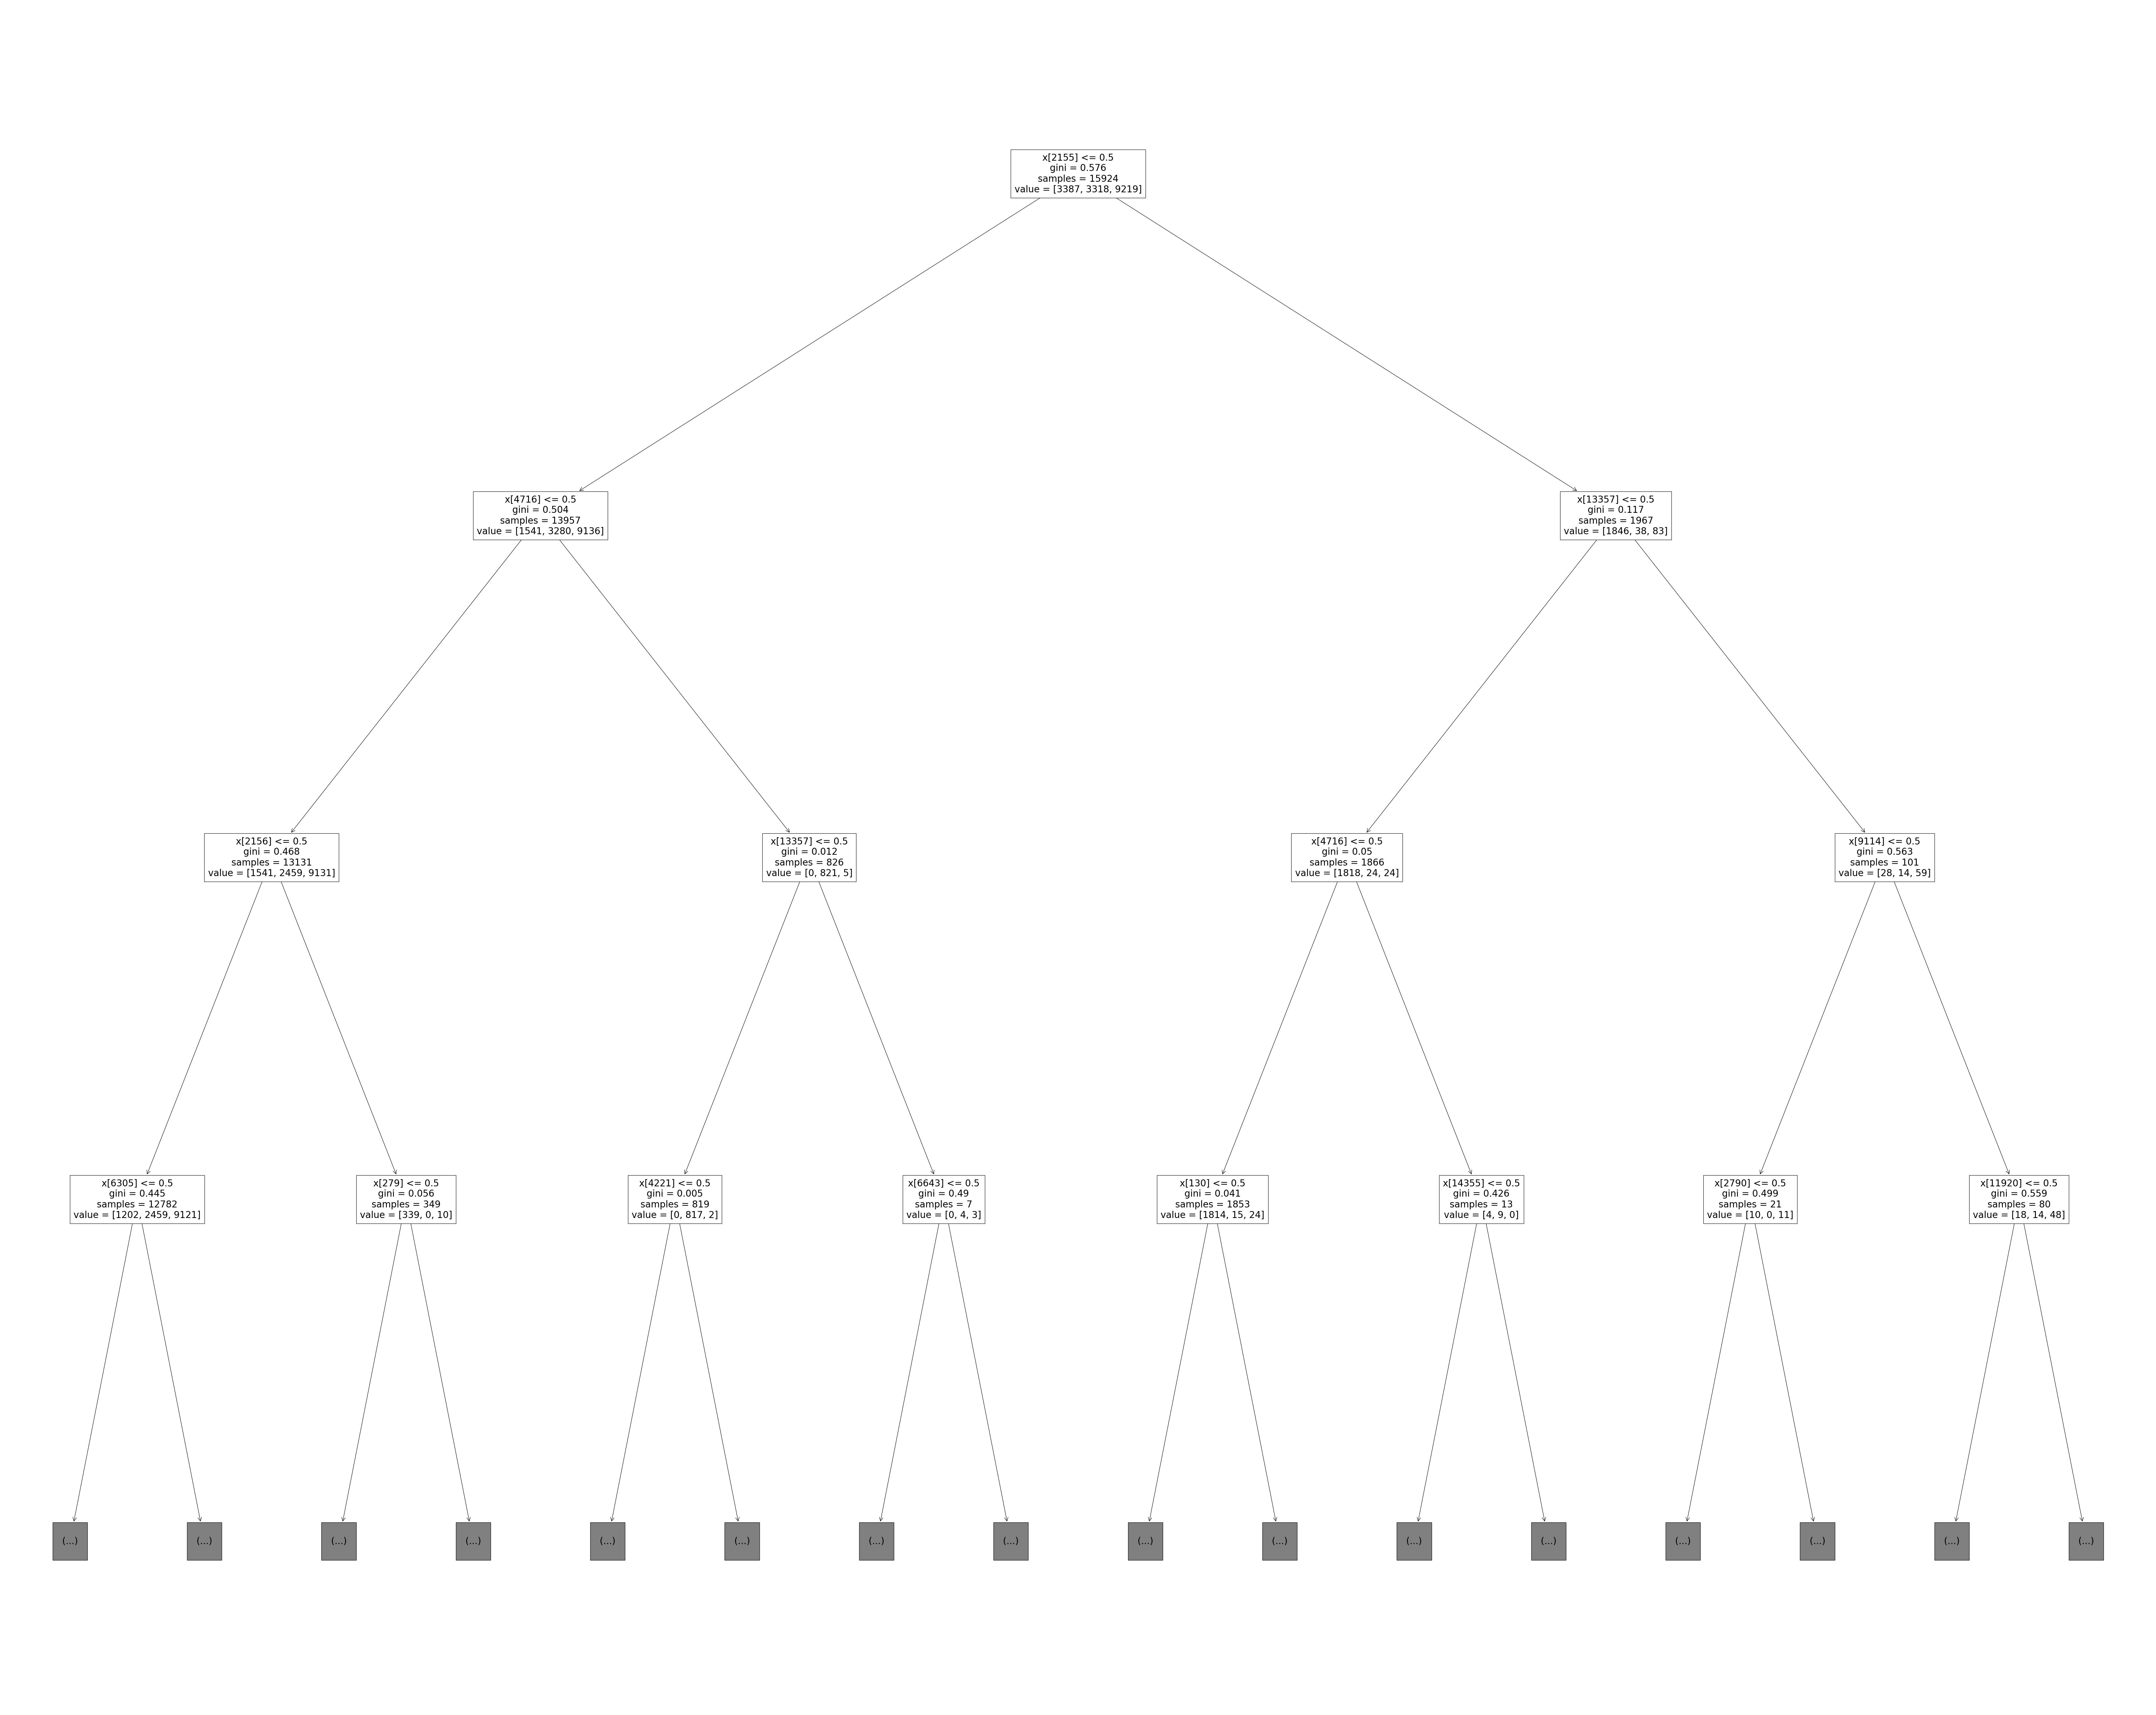

In [11]:
from sklearn import tree

fig, ax = plt.subplots(figsize=(100, 80))                # set the demension tree
tree.plot_tree(dt, max_depth=3, ax=ax)  # plot it as the tree-like appearence
plt.show() #show the tree graph

### Multinomial Naive Bayesian



In [12]:
# Create a Multinomial Naive Bayes classifier
nb = MultinomialNB()

# Train the Naive Bayes classifier on the training data
nb.fit(Xtr, Ytr)

# Make predictions on the test set
pred = nb.predict(Xte)

# Print the classification report, including precision, recall, and F1-score
print("Multinomial Naive Bayes Classifier:")
print(classification_report(Yte, pred, target_names=encoder.classes_))

Multinomial Naive Bayes Classifier:
              precision    recall  f1-score   support

           b       0.89      0.84      0.87       824
           e       0.88      0.83      0.86       847
           t       0.91      0.94      0.92      2310

    accuracy                           0.90      3981
   macro avg       0.89      0.87      0.88      3981
weighted avg       0.90      0.90      0.90      3981



### Artificial Neural Network



In [13]:
# Create an Artificial Neural Network (ANN) classifier
ann = MLPClassifier(hidden_layer_sizes=(128, 128, 128), max_iter=1000, activation='relu', solver='adam')

# Train the ANN on the training data
ann.fit(Xtr, Ytr)

# Make predictions on the test set
pred_ann = ann.predict(Xte)

# Print the classification report, including precision, recall, and F1-score
print("Artificial Neural Network:")
print(classification_report(Yte, pred_ann, target_names=encoder.classes_))

Artificial Neural Network:
              precision    recall  f1-score   support

           b       0.93      0.87      0.90       824
           e       0.92      0.87      0.90       847
           t       0.92      0.96      0.94      2310

    accuracy                           0.92      3981
   macro avg       0.93      0.90      0.91      3981
weighted avg       0.92      0.92      0.92      3981



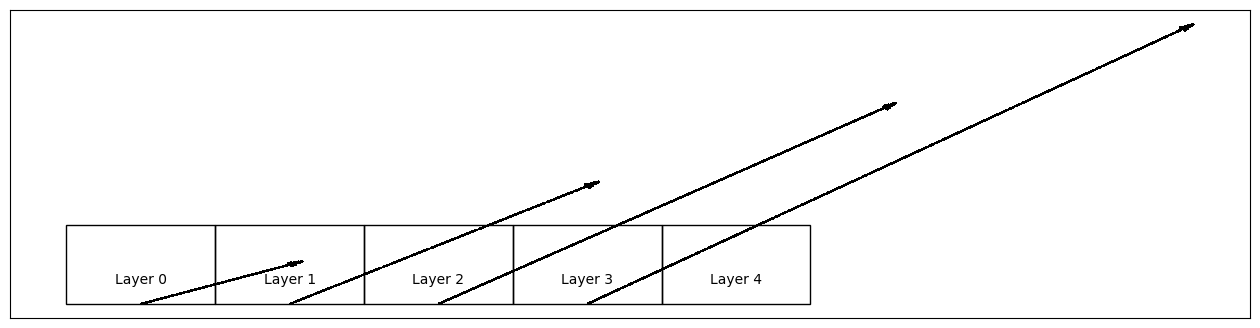

In [14]:
import matplotlib.patches as patches

# Get the number of layers in the neural network
num_layers = len(ann.coefs_)

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(16, 4))

# Set the positions for drawing the layers
layer_positions = [i for i in range(num_layers + 1)]

# Plot the layers as rectangles
for i in range(num_layers + 1):
    rect = patches.Rectangle((i - 0.5, -0.5), 1, 1, linewidth=1, edgecolor='black', facecolor='none')
    ax.add_patch(rect)
    ax.text(i, -0.2, f"Layer {i}", ha='center', va='center')

# Plot the connections between layers
for i in range(num_layers):
    for j in range(ann.coefs_[i].shape[0]):
        for k in range(ann.coefs_[i].shape[1]):
            ax.arrow(i, -0.5, i + 1, layer_positions[i + 1] - 0.5,
                     head_width=0.05, head_length=0.1, fc='black', ec='black', linestyle='dashed')

# Remove axis ticks and labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

plt.show()

## Conclusion:

After running the dataset through all three algorithms, we found that Artificial Neural Network is the most accurate, with 92% acuurate. The other two is not far behind, Decision tree is 91% accurate and Multinominal Naive Bayesian 90% accurate.


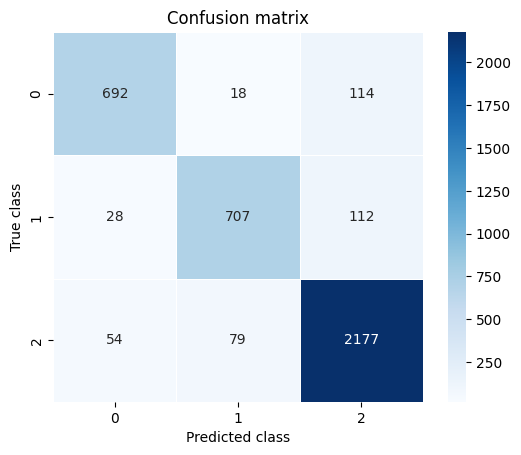

In [18]:
# Create a confusion matrix
cm = confusion_matrix(Yte, pred)

#plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5, square=True)
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Confusion matrix')
plt.show()